# location changed to D6

In [311]:
# Setup the library
import pyrogue.utilities.fileio as fileio
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import struct
from scipy.stats import norm
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
top_level=f'{os.getcwd()}/..'

In [312]:
def datfile(filename):
    # Waveforms variables to be filled 
    ampFault = { i : []  for i in range(4) }  
    xPosFault = []
    yPosFault = []
    qBunchFault = []
    recordtime = []
    
    # Open the .dat file
    with fileio.FileReader(files=f'{top_level}/datfile/'+filename) as fd:
        
        # Loop through the file data
        for header,data in fd.records():
    
            # Check if there is a 8-byte header in the frame
            if (header.flags==0):
                hdrOffset = 8
                hdr = struct.unpack("<d", data[:8])[0]
                timestamp = time.localtime(hdr)
                # Define the desired format string (replace with your preferred format)
                # Some common format specifiers:
                # %Y - Year with century
                # %m - Month as a decimal number (01-12)
                # %d - Day of the month as a decimal number (01-31)
                # %H - Hour in 24-hour format (00-23)
                # %M - Minute (00-59)
                # %S - Second (00-59)
                
                formatted_time = time.strftime('%Y-%m-%d_%H-%M-%S', timestamp)
                #print( f'CH={header.channel}: Event Timestamp in human-readable format: {formatted_time}' )
                if header.channel==24:
                    recordtime.append(formatted_time)
            
            else:
                hdrOffset = 0
                print( 'No timestamp header detected' )
            
            # Check for error in frame
            if (header.error>0):
                # Look at record header data
                print(f"Processing record. Total={fd.totCount}, Current={fd.currCount}")
                print(f"Record size    = {header.size}")
                print(f"Record channel = {header.channel}")
                print(f"Record flags   = {header.flags:#x}")
                print(f"Record error   = {header.error:#x}")
    
            # Check if AMP Fault waveform
            elif (header.channel < 16) and (header.channel >= 12):
                ampFault[header.channel-12].append(data[hdrOffset:].view(np.int16))
    
            # Check if AMP Live waveform
            elif header.channel == 24:
                fpData = data[hdrOffset:].view(np.float32)
                fpDataLen = len(fpData)
                xPosFault.append(   fpData[0:(fpDataLen*3)+0:3] ) 
                yPosFault.append(   fpData[1:(fpDataLen*3)+1:3] )
                qBunchFault.append( fpData[2:(fpDataLen*3)+2:3] )
            
            # Else undefined stream index
            else:
                print( f'UNDEFINED DATA STREAM[{header.channel}]!!!')
    return ampFault, recordtime

In [443]:
def make_heatmap(filename,lim):
    ampFault, recordtime=datfile(filename)
    eventnum=0
    print(f'Recorded time : {recordtime}')
    
    def bunchindex(threshold,waveform):
        start=23500
        firstbunch=0
        for i in range(1,8*2000):
            if waveform[start+i-1]<waveform[start+i] and waveform[start+i]>waveform[start+i+1]:
                if waveform[start+i]>threshold:
                    firstbunch=start+i
                    break
        if firstbunch==0:
            print("data is not invalid")
            return firstbunch, 0
    
        bunch_candidate=waveform[firstbunch:firstbunch+5120*8:8]
        bunch_index=np.where(bunch_candidate>threshold)[0]
    
        return firstbunch, bunch_index

    firstbunch, bunch_index=bunchindex(1000,ampFault[2][eventnum])
    if firstbunch==0:
        print("end process")
        return
    
    print(f'Num of bunch : {len(bunch_index)}')
    print(f'First bunch index : {firstbunch}')
    print(bunch_index)
    y_pos=[]
    x_pos=[]
    charge=[]
    for j in bunch_index:
        certain_bunch=[]
        certain_bunch_x=[]
        certain_bunch_charge=[]
        for i in range(12):
            sum_1=ampFault[2][eventnum][firstbunch+j*8+5120*8*i]
            sum_2=ampFault[3][eventnum][firstbunch+j*8+5120*8*i]
            sum=sum_1+sum_2
            delta_U=ampFault[0][eventnum][firstbunch+j*8+5120*8*i+1]
            delta_V=ampFault[1][eventnum][firstbunch+j*8+5120*8*i+1]
            Uposition=delta_U/sum_1
            Vposition=delta_V/sum_2
            xposition=Uposition-Vposition
            yposition=Uposition+Vposition
            certain_bunch.append(yposition)
            certain_bunch_x.append(xposition)
            certain_bunch_charge.append(sum)
        y_pos.append(np.array(certain_bunch))
        x_pos.append(np.array(certain_bunch_x))
        charge.append(np.array(certain_bunch_charge))
    y_pos=np.array(y_pos)
    x_pos=np.array(x_pos)
    charge=np.array(charge)

    mean=np.mean(y_pos[:,0:2],axis=1)
    y_pos=y_pos-mean[:,np.newaxis]
    mean=np.mean(x_pos[:,0:2],axis=1)
    x_pos=x_pos-mean[:,np.newaxis]
    charge_mean=np.mean(charge[:,0:2],axis=1)
    charge=charge/charge_mean[:,np.newaxis]
            
    #make x axis
    bunch_index_12=[]
    for i in range(12):
        bunch_index_12.append(bunch_index+5120*i)

    x_axis=np.concatenate(bunch_index_12)/5120+1
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True,figsize=(36,16))
    split=np.hsplit(x_pos,x_pos.shape[1])
    ax1.set_title(f'{recordtime[0]}   Nb={len(bunch_index)}')
    ax1.scatter(x_axis,np.concatenate(split),color='red',s=6)
    ax1.set_ylabel("X position (a.u.)")
    ax1.set_ylim(-0.6,0.6)
    ax1.grid()
    ax1.text(0.02,0.05,'D6 Horizontal',transform=ax1.transAxes,ha='left',va='bottom',fontsize=20)
    
    split=np.hsplit(y_pos,y_pos.shape[1])
    ax2.scatter(x_axis,np.concatenate(split),color='red',s=6)
    ax2.set_ylabel("Y position (a.u.)")
    ax2.set_ylim(-0.6,0.6)
    ax2.grid()
    ax2.text(0.02,0.05,'D6 Vertical',transform=ax2.transAxes,ha='left',va='bottom',fontsize=20)


    split=np.hsplit(charge,charge.shape[1])
    ax3.scatter(x_axis,np.concatenate(split).reshape(len(x_axis)),color='blue',s=6)
    ax3.set_xlabel("Turn")
    ax3.set_ylabel("Charge")
    ax3.set_ylim(0,1.2)
    ax3.grid()
    ax3.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13],['1','2','3','4','5','6','7','8','9','10','11','12','abort'])
    ax3.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax3.set_xlim(lim,13)
    ax3.text(0.02,0.05,'D6 Charge',transform=ax3.transAxes,ha='left',va='bottom',fontsize=20)

    
    plt.subplots_adjust(hspace=.1)
    #plt.savefig("beamloss2.png",dpi=200)
    plt.show()
    

1
2024-04-23_22-00-39


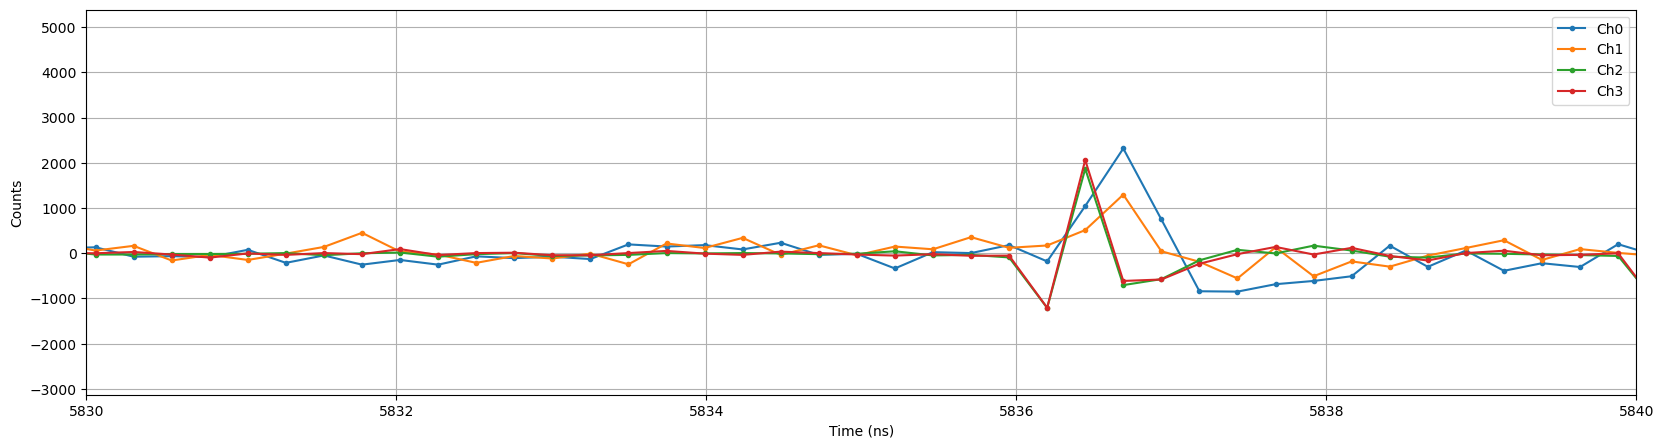

In [428]:
ampFault,recordtime=datfile("data_20240423_171128.dat")

print(len(recordtime))
eventnum=0
size = len(ampFault[0][eventnum])

print(recordtime[eventnum])
timeBin = 1.0/(0.509*8.0) # Unit of ns for 4.072 GSPS
timeSteps = np.linspace(0, timeBin*(size-1), num=size)

# Plot the Waveform Full Scale
plt.figure(figsize=(20,5))
start=23790
plt.plot(timeSteps,ampFault[0][eventnum],label="Ch0",marker='o',markersize=3)
plt.plot(timeSteps,ampFault[1][eventnum],label="Ch1",marker='o',markersize=3)
plt.plot(timeSteps,ampFault[2][eventnum],label="Ch2",marker='o',markersize=3)
plt.plot(timeSteps,ampFault[3][eventnum],label="Ch3",marker='o',markersize=3)
plt.xlabel("Time (ns)")
plt.ylabel("Counts")
plt.xlim(5830,5840)
plt.legend()
plt.grid()

Recorded time : ['2024-04-24_18-37-50']
Num of bunch : 2346
First bunch index : 23766
[   0    2    4 ... 4949 4951 4955]


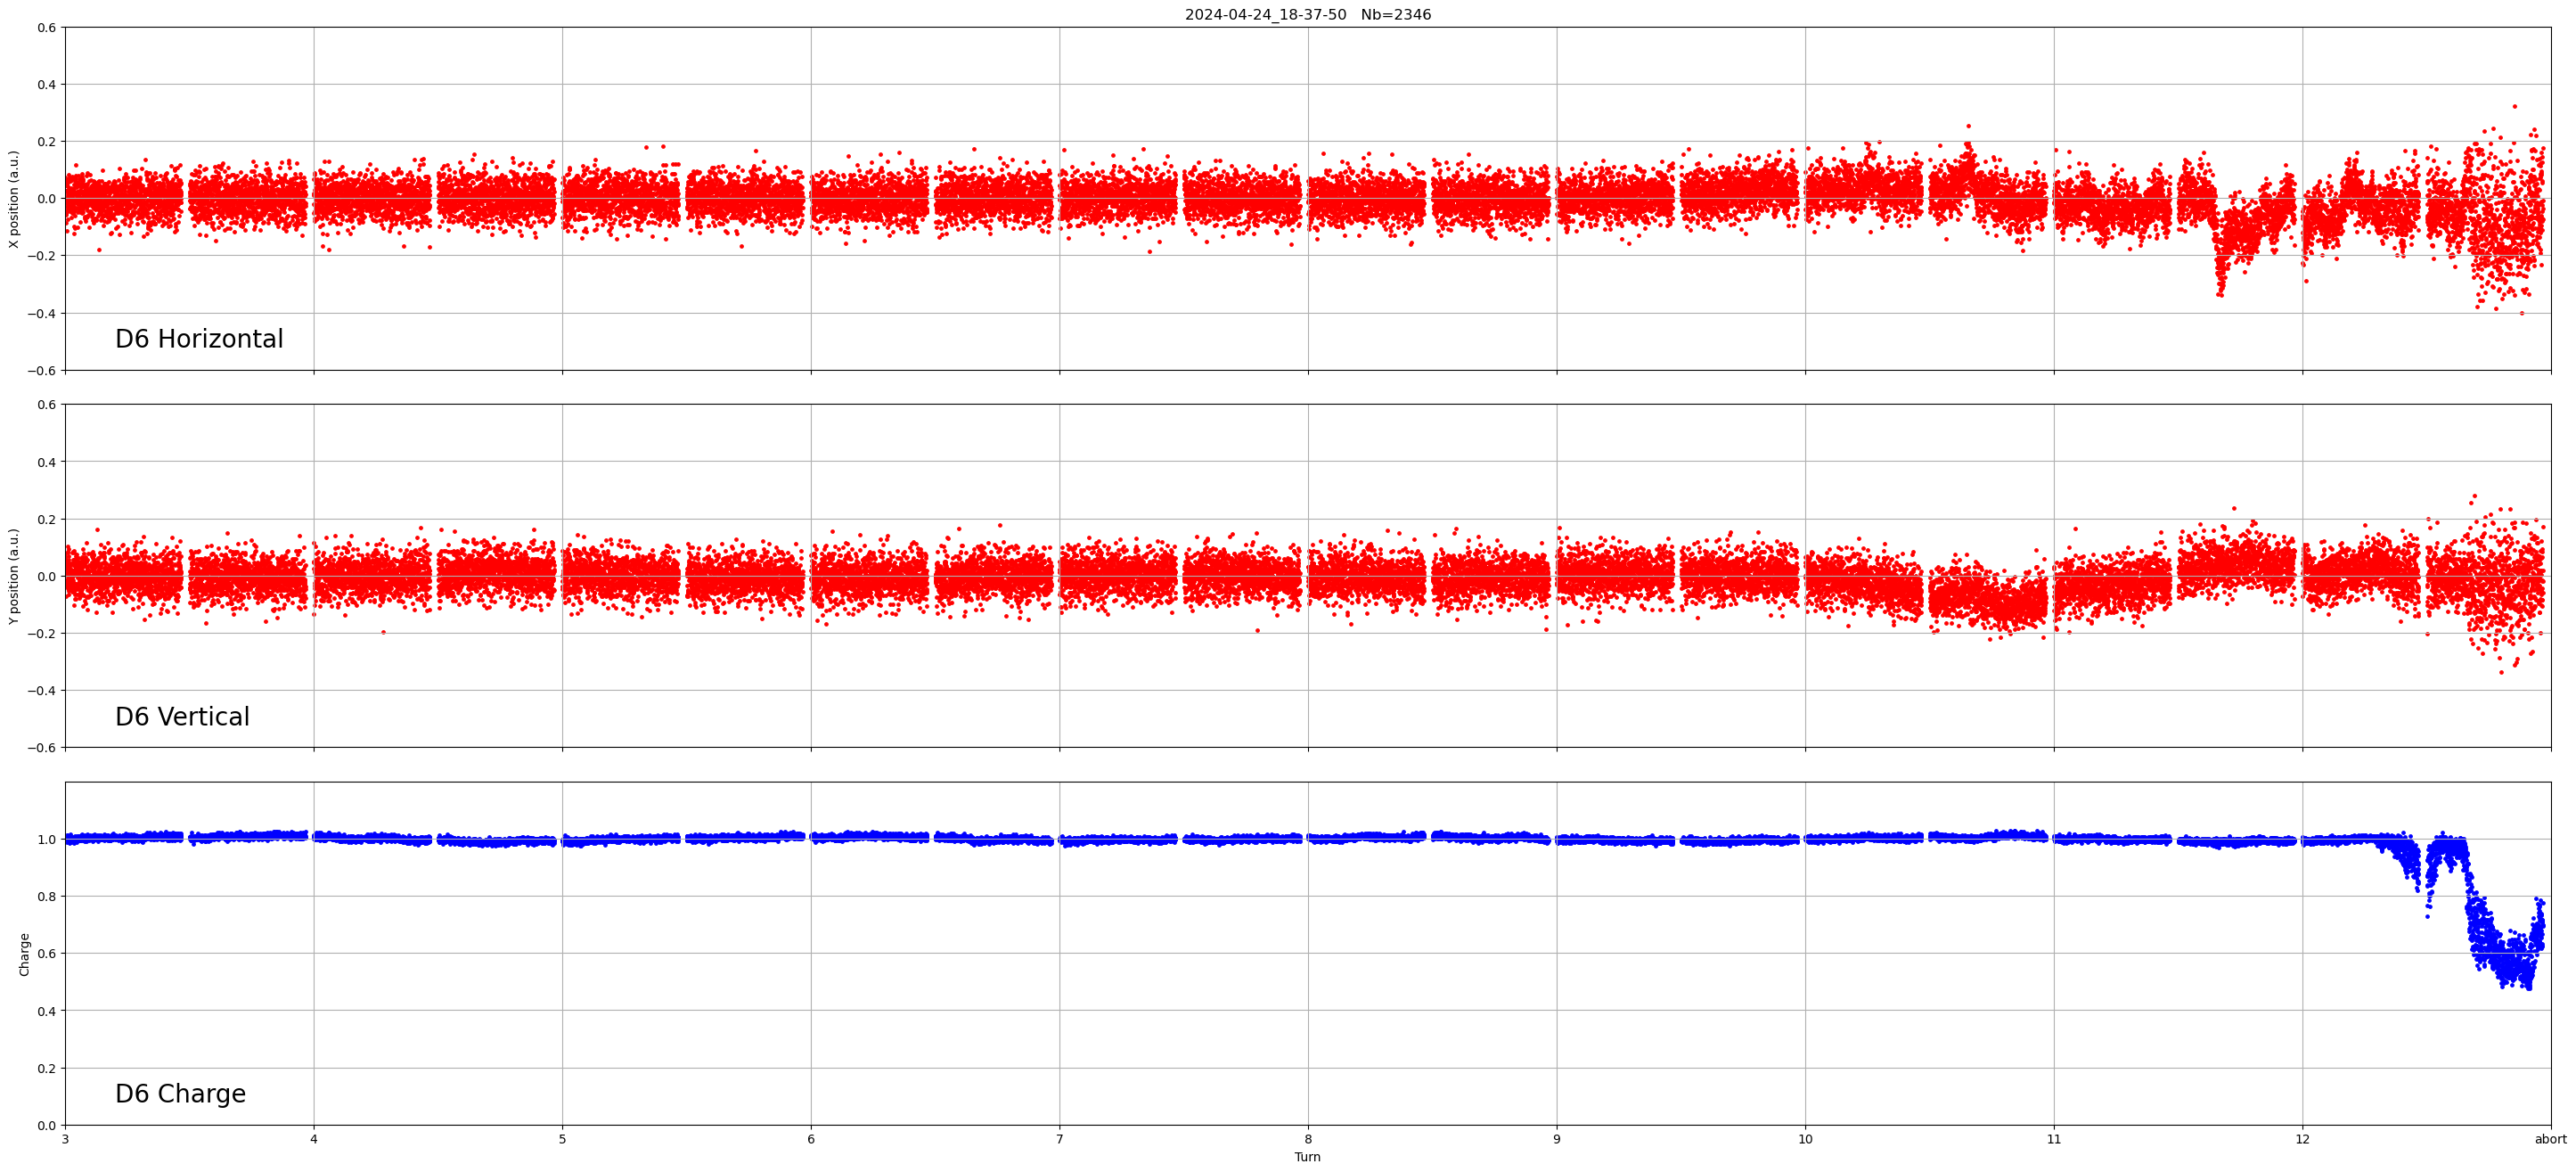

In [444]:
make_heatmap("data_20240424_124021.dat",3)

Recorded time : ['2024-04-18_10-00-12']
Num of bunch : 2346
First bunch index : 23790


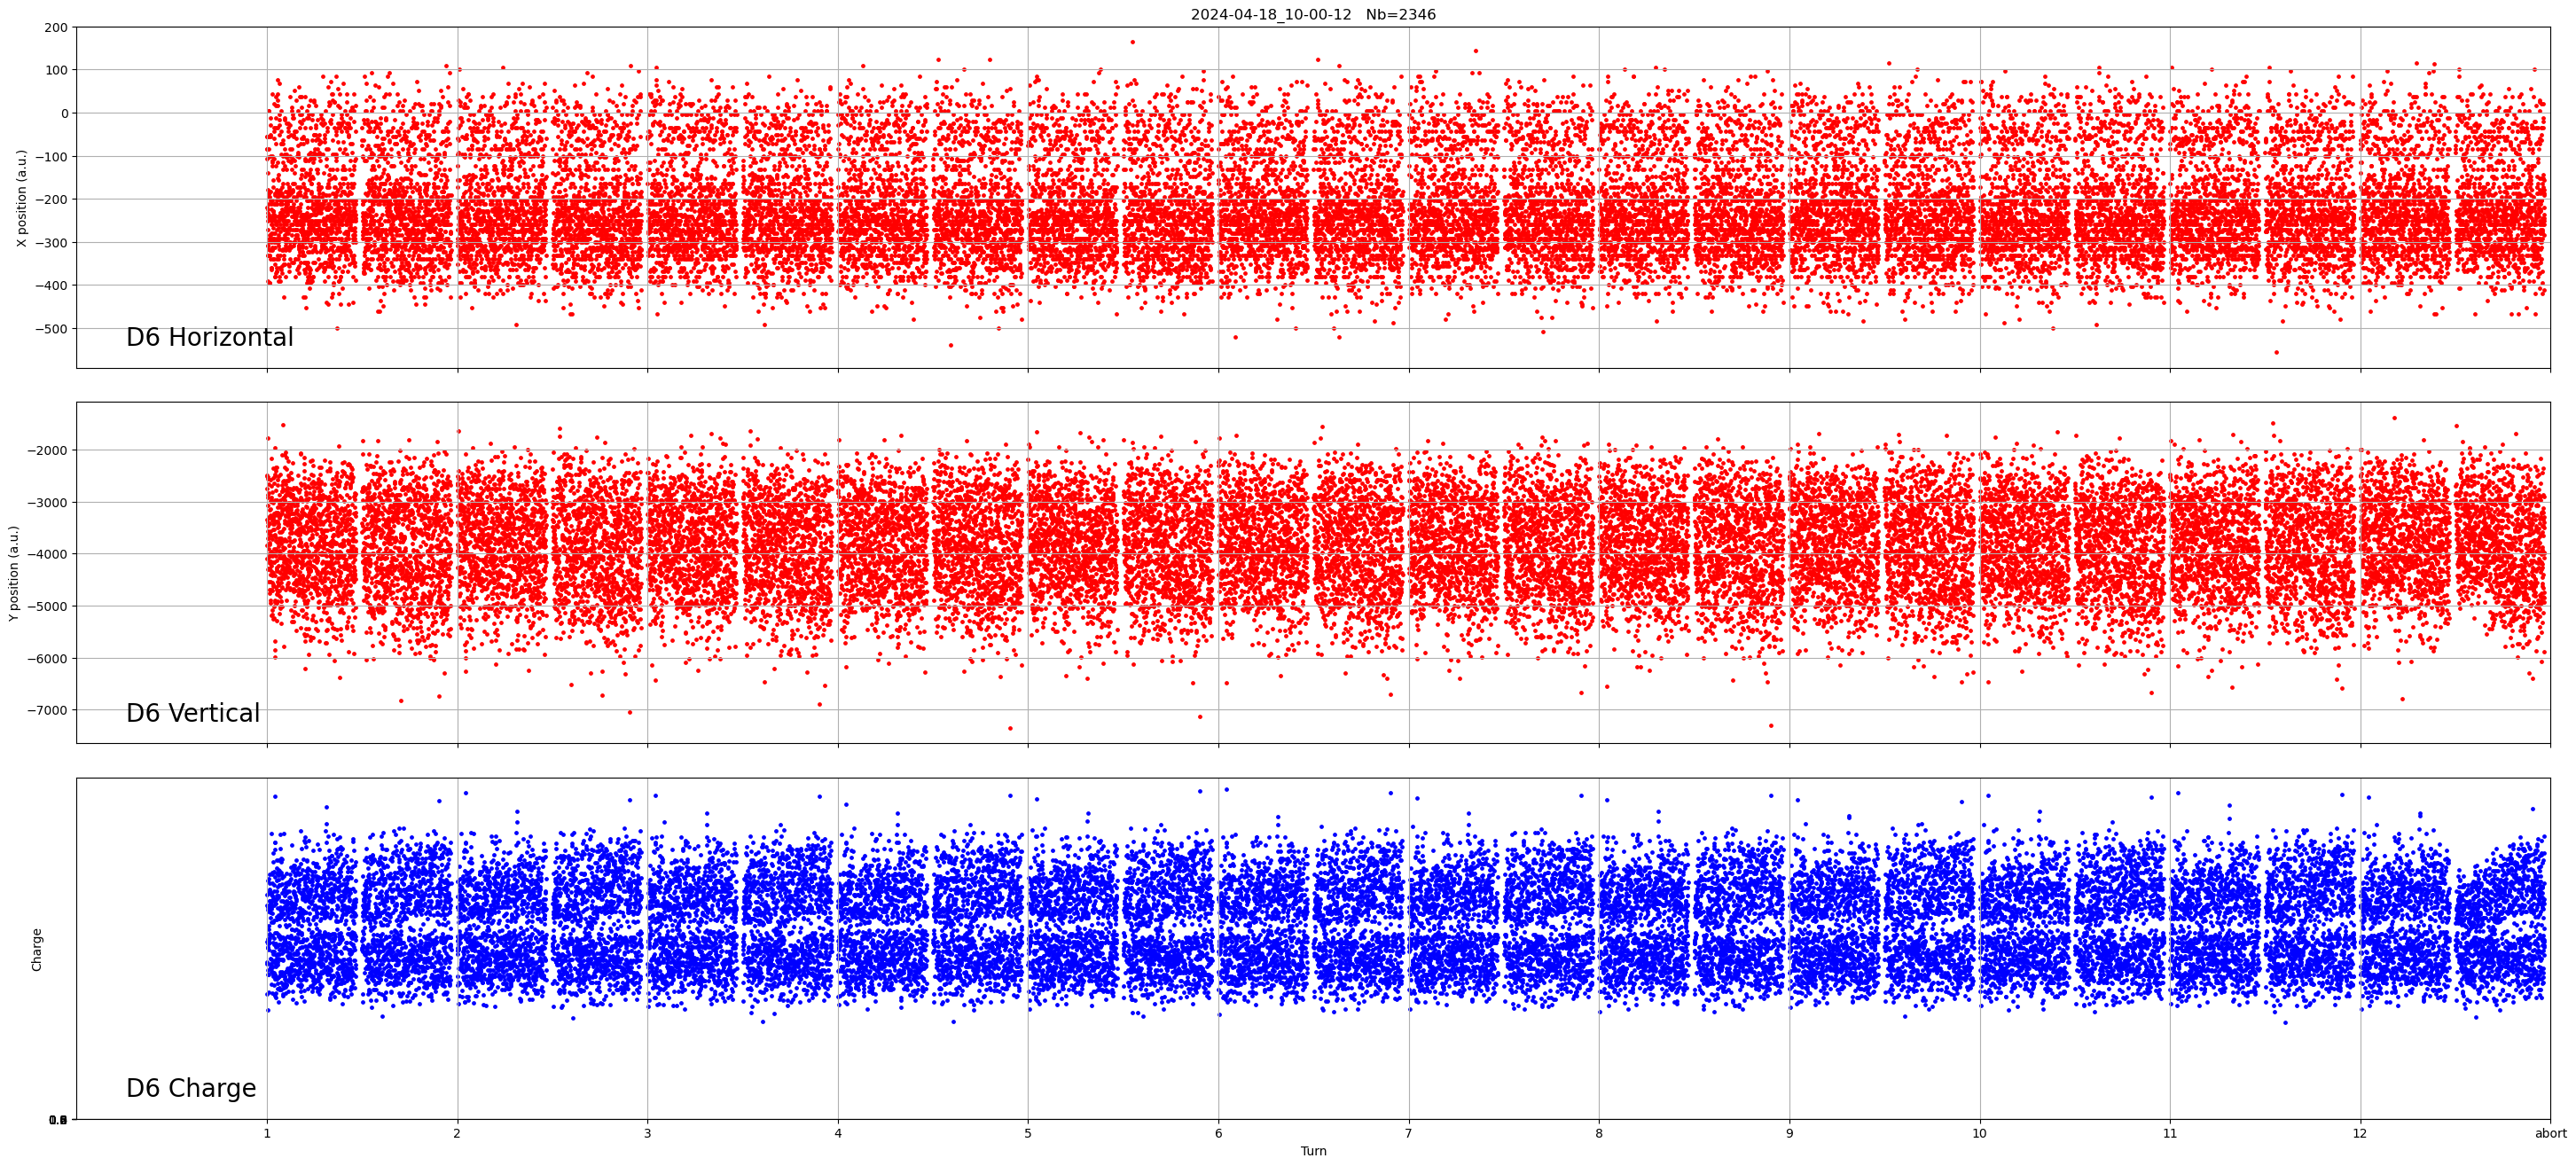

In [282]:
ampFault, recordtime=datfile("data_20240418_090717.dat")
eventnum=0
print(f'Recorded time : {recordtime}')

def bunchindex(threshold,waveform):
    start=23500
    firstbunch=0
    for i in range(1,8*2000):
        if waveform[start+i-1]<waveform[start+i] and waveform[start+i]>waveform[start+i+1]:
            if waveform[start+i]>threshold:
                firstbunch=start+i
                break
    if firstbunch==0:
        print("data is not invalid")
        return firstbunch, 0

    bunch_candidate=waveform[firstbunch:firstbunch+5120*8:8]
    bunch_index=np.where(bunch_candidate>threshold)[0]

    return firstbunch, bunch_index

firstbunch, bunch_index=bunchindex(400,ampFault[2][eventnum])

print(f'Num of bunch : {len(bunch_index)}')
print(f'First bunch index : {firstbunch}')
y_pos=[]
x_pos=[]
charge=[]
for j in bunch_index:
    certain_bunch=[]
    certain_bunch_x=[]
    certain_bunch_charge=[]
    for i in range(12):
        sum=ampFault[2][eventnum][firstbunch+j*8+5120*8*i]
        delta_y=ampFault[1][eventnum][firstbunch+j*8+5120*8*i]
        delta_x=ampFault[0][eventnum][firstbunch+j*8+5120*8*i-1]
        yposition=delta_y#/sum*23.575*5/74/6
        xposition=delta_x#/sum*23.575*5/14.8/6
        certain_bunch.append(yposition)
        certain_bunch_x.append(xposition)
        certain_bunch_charge.append(sum)
    y_pos.append(np.array(certain_bunch))
    x_pos.append(np.array(certain_bunch_x))
    charge.append(np.array(certain_bunch_charge))
y_pos=np.array(y_pos)
x_pos=np.array(x_pos)
charge=np.array(charge)

#mean=np.mean(y_pos[:,0:2],axis=1)
#y_pos=y_pos-mean[:,np.newaxis]
#mean=np.mean(x_pos[:,0:2],axis=1)
#x_pos=x_pos-mean[:,np.newaxis]
#charge_mean=np.mean(charge[:,0:2],axis=1)
#charge=charge/charge_mean[:,np.newaxis]
        
#make x axis
bunch_index_12=[]
for i in range(12):
    bunch_index_12.append(bunch_index+5120*i)

x_axis=np.concatenate(bunch_index_12)/5120+1

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True,figsize=(36,16))
split=np.hsplit(x_pos,x_pos.shape[1])
ax1.set_title(f'{recordtime[0]}   Nb={len(bunch_index)}')
ax1.scatter(x_axis,np.concatenate(split),color='red',s=6)
ax1.set_ylabel("X position (a.u.)")
#ax1.set_ylim(-1,1)
ax1.grid()
ax1.text(0.02,0.05,'D6 Horizontal',transform=ax1.transAxes,ha='left',va='bottom',fontsize=20)

split=np.hsplit(y_pos,y_pos.shape[1])
ax2.scatter(x_axis,np.concatenate(split),color='red',s=6)
ax2.set_ylabel("Y position (a.u.)")
#ax2.set_ylim(-1,1)
ax2.grid()
ax2.text(0.02,0.05,'D6 Vertical',transform=ax2.transAxes,ha='left',va='bottom',fontsize=20)


split=np.hsplit(charge,charge.shape[1])
ax3.scatter(x_axis,np.concatenate(split).reshape(len(x_axis)),color='blue',s=6)
ax3.set_xlabel("Turn")
ax3.set_ylabel("Charge")
#ax3.set_ylim(0,1.2)
ax3.grid()
ax3.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13],['1','2','3','4','5','6','7','8','9','10','11','12','abort'])
ax3.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax3.set_xlim(0,13)
ax3.text(0.02,0.05,'D6 Charge',transform=ax3.transAxes,ha='left',va='bottom',fontsize=20)


plt.subplots_adjust(hspace=.1)
#plt.savefig("beamloss2.png",dpi=200)
plt.show()

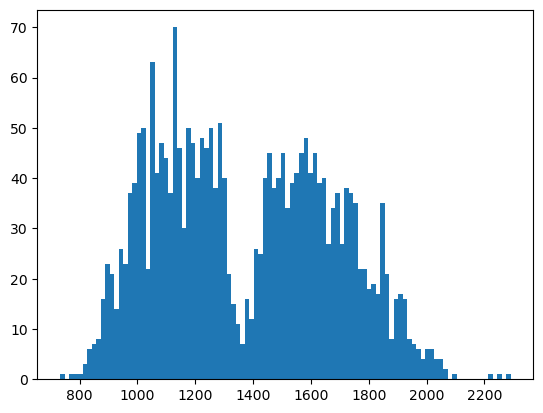

In [283]:
split=np.hsplit(charge,charge.shape[1])
plt.hist(charge[:,0],bins=100)
plt.show()

Recorded time : ['2024-04-18_05-40-52']
Num of bunch : 2346
First bunch index : 23790


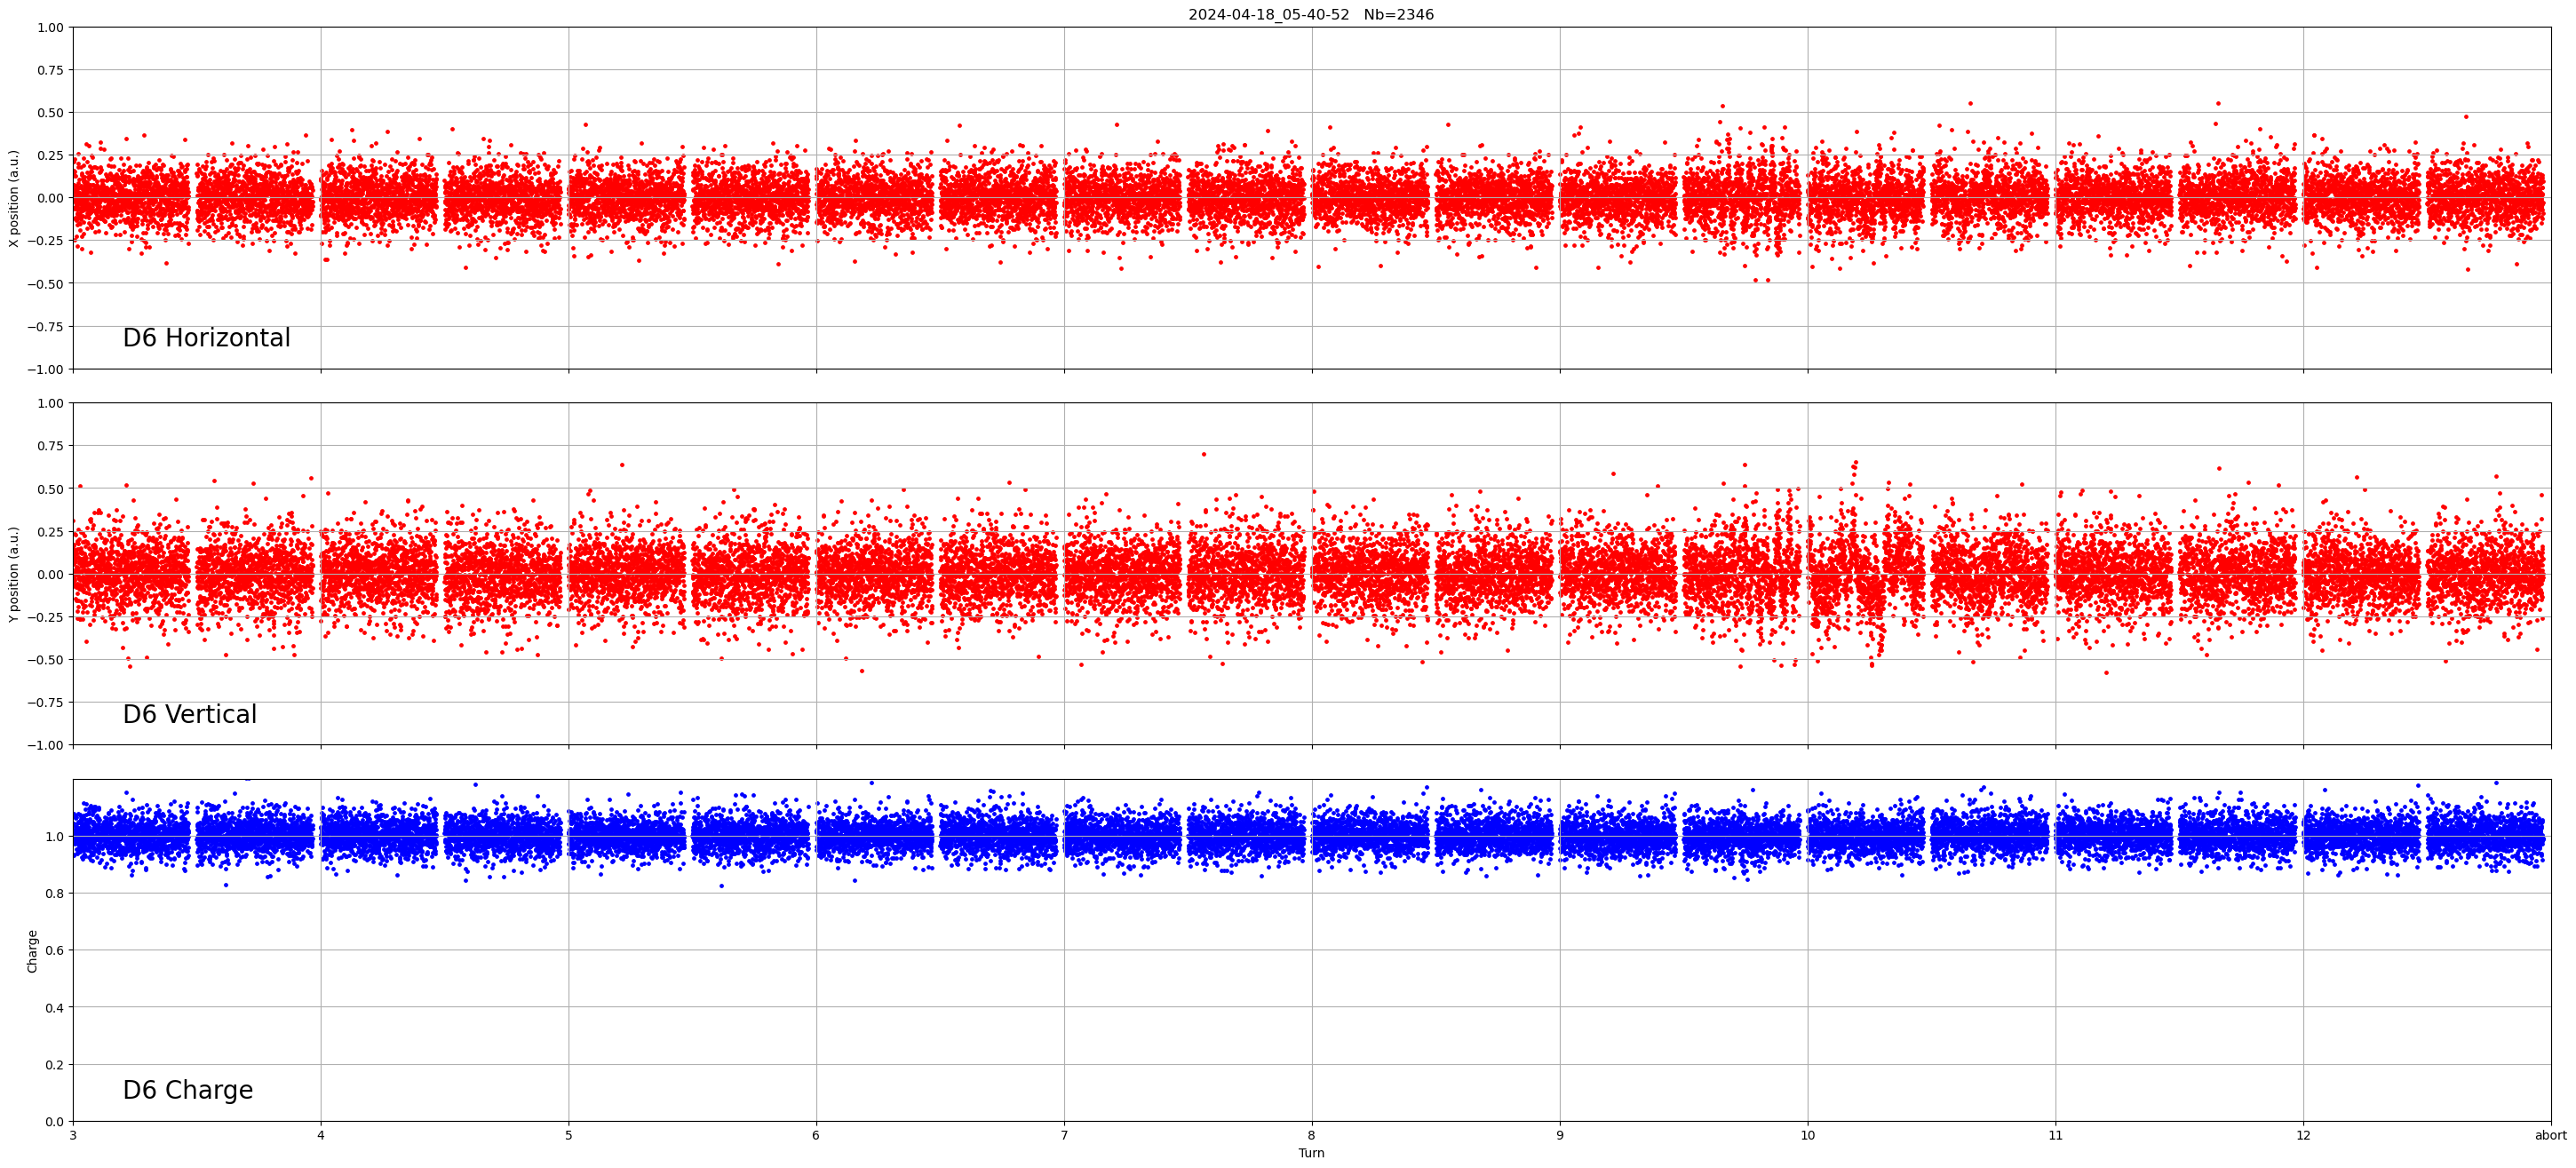

In [163]:
make_heatmap("data_20240418_012634.dat",3)

Recorded time : ['2024-04-17_06-45-31']
Num of bunch : 2346
First bunch index : 23790


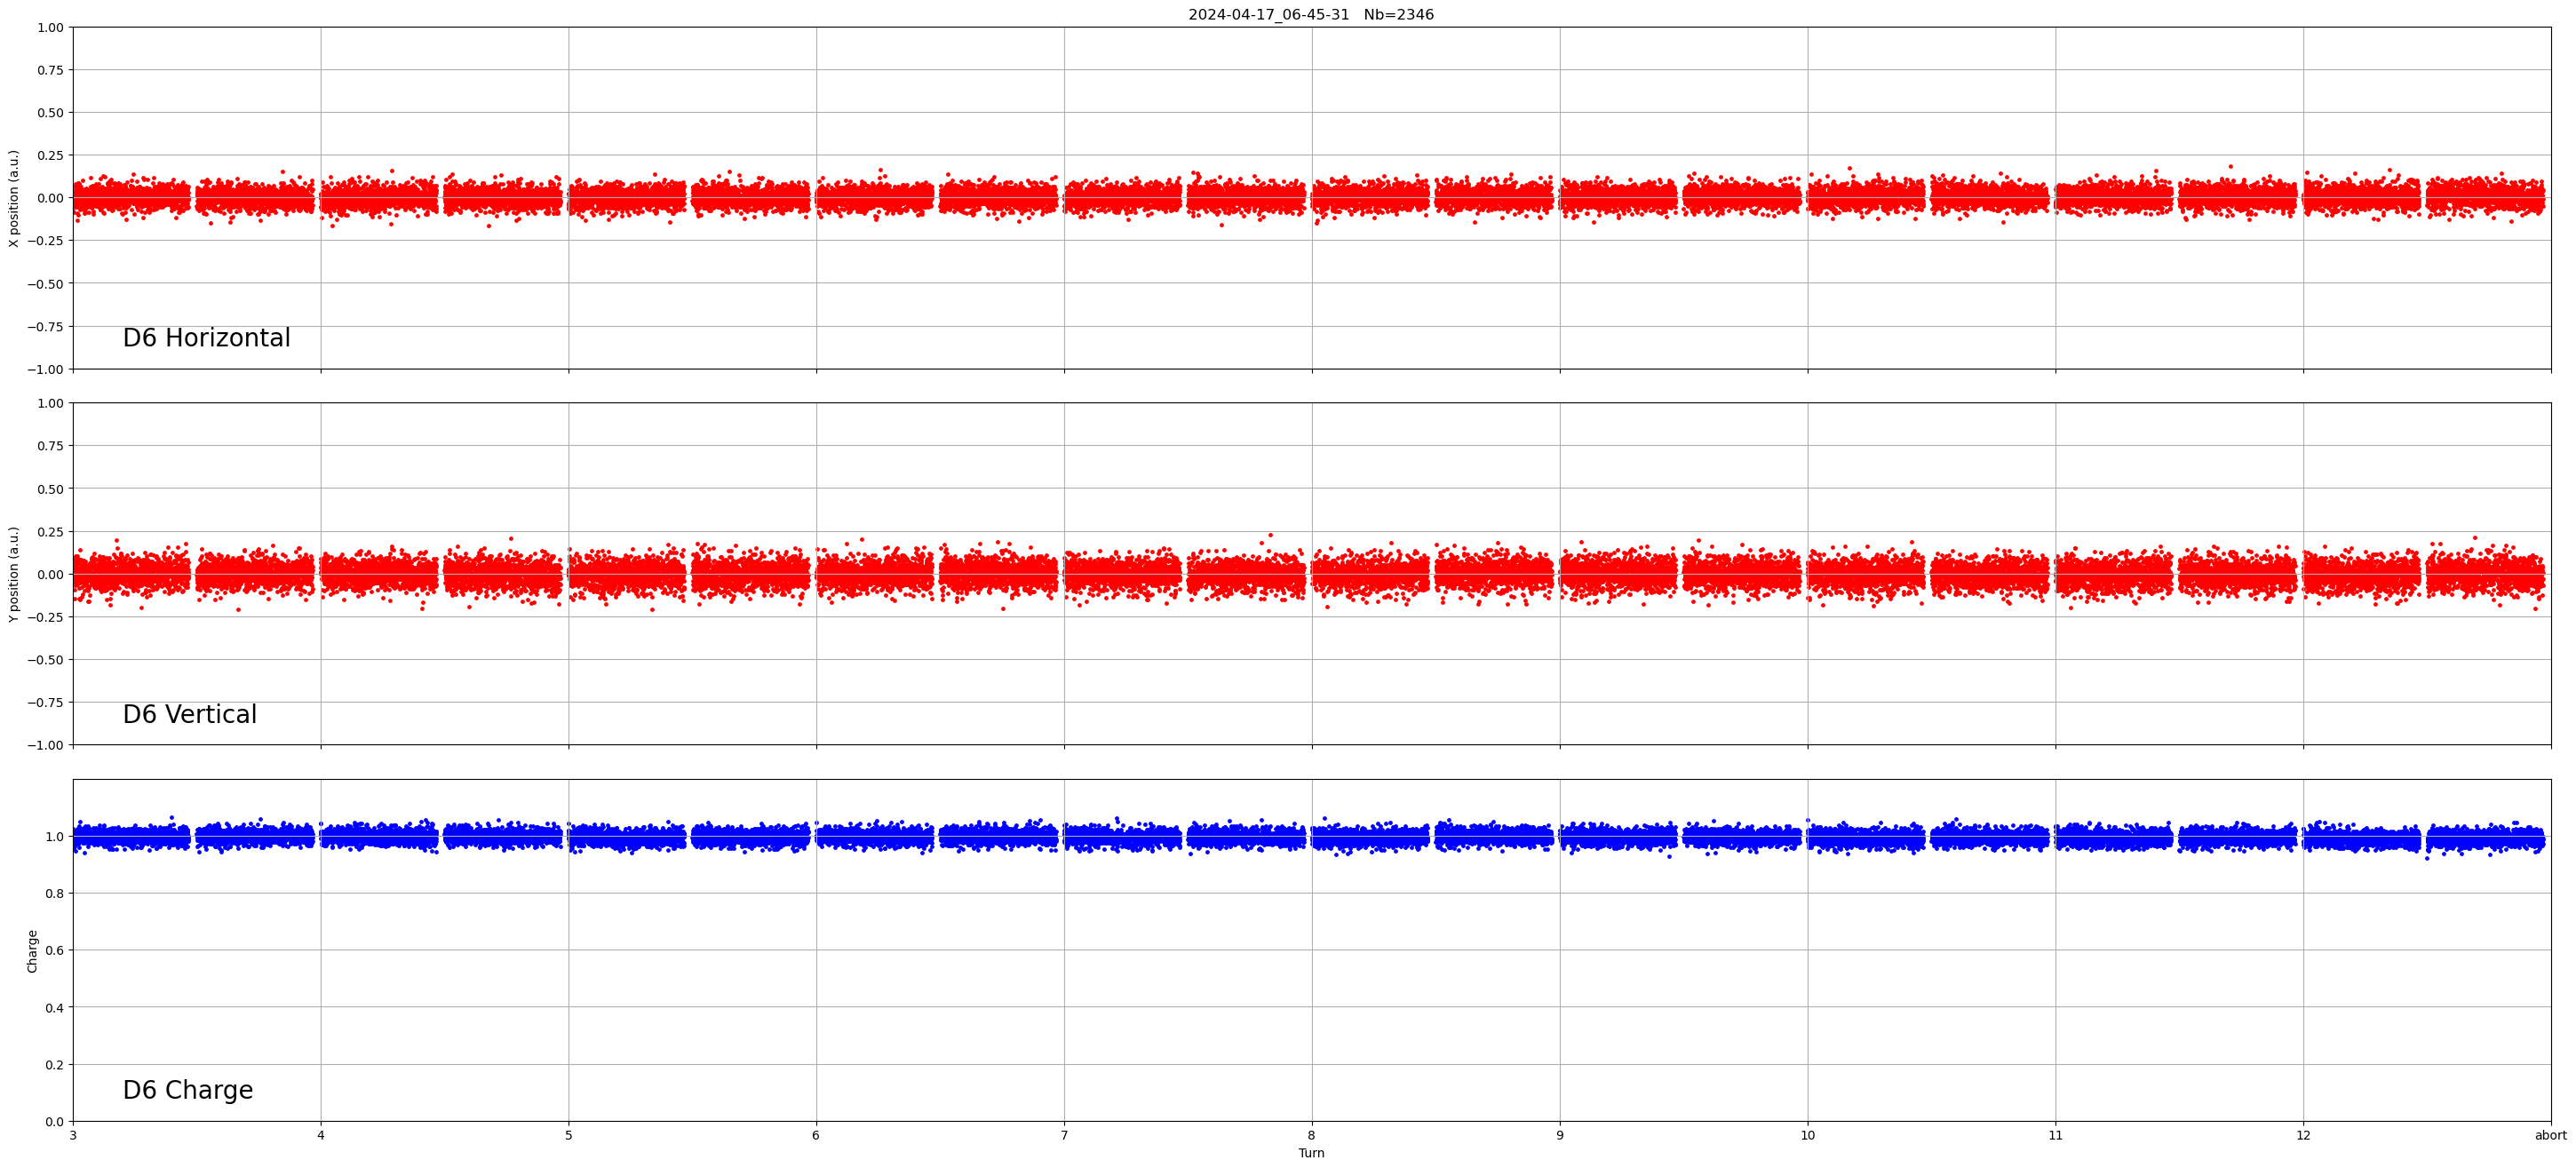

In [162]:
make_heatmap('data_20240417_032359.dat',3)